# Next-Word Prediction with LSTM (Sequential Learning)

This notebook demonstrates how recurrent neural networks (RNNs) — specifically an LSTM — can be used for forecasting in language by suggesting the next word in a sentence. It uses pretrained GloVe embeddings and a many-to-one sequence mapping strategy to predict the next token given the prior context.

## Problem statement
Given a large corpus of text, build a model that, for a given input sequence of words (length n), predicts the next word (n+1). We use a many-to-one sequence mapper and consider the entire sentence context (sequences of words), not isolated words. We then evaluate the model and generate completions for user-provided prompts.

## Algorithm and approach
- Clean and normalize text; remove punctuation and lowercase.
- Tokenize words and build a vocabulary using Keras Tokenizer.
- Build supervised examples with a sliding window: for a sequence length `SEQ_LEN`, use words `[i .. i+SEQ_LEN-1]` as features and word `i+SEQ_LEN` as the label.
- Map tokens to integers, and feed sequences to a Keras model:
  - Embedding: either pretrained GloVe (100d) with `trainable=False` or randomly initialized trainable embeddings.
  - Masking: when using pretrained embeddings, mask any time steps whose embedding vector is all zeros (words with no pretrained vector). When training embeddings from scratch, do not use this Masking layer.
  - LSTM layer with dropout.
  - Dense (ReLU) + Dropout for capacity and regularization.
  - Output Dense with softmax over the vocabulary.
- Train with Adam optimizer, EarlyStopping, and ModelCheckpoint.
- Explore embeddings via cosine similarity.
- Generate next-word predictions for prompts using greedy or temperature sampling.

## Data set
We use the WikiText-2 corpus (a cleaned subset of Wikipedia) as a suitable training dataset. It balances size and accessibility for demonstration. For higher accuracy, consider scaling to WikiText-103 or larger corpora.

- WikiText-2 download: Metamind S3 (free, public).
- Alternative: Provide your own corpus by placing text files under `./data/custom/`.

Note: Model performance generally improves with more data, longer training, and larger models.

In [ ]:
import os
import io
import re
import json
import math
import time
import random
import zipfile
import string
import shutil
import requests
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

print('TensorFlow version:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'
EMB_DIR = DATA_DIR / 'embeddings'
for d in [DATA_DIR, MODELS_DIR, EMB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

TensorFlow version: 2.20.0
GPU available: []


In [ ]:
CFG = {
    'SEQ_LEN': 20,
    'MAX_VOCAB': 50000,
    'VAL_SPLIT': 0.1,
    'EMB_DIM': 100,
    'USE_PRETRAINED': True,
    'TRAINABLE_EMB': False,
    'LSTM_UNITS': 128,
    'DENSE_UNITS': 128,
    'DROPOUT': 0.3,
    'BATCH_SIZE': 256,
    'EPOCHS': 30,
    'MAX_SAMPLES': None,
    'DATASET': 'wikitext-2',
    'DATASET_SOURCE': 'kaggle',
    'FAST_RUN': True,
    'FAST_EPOCHS': 15,
    'STEPS_PER_EPOCH': None,
    'VAL_STEPS': None,
    'EARLY_STOPPING': True,
    'ES_MONITOR': 'val_loss',
    'ES_PATIENCE': 3,
    'ES_MIN_DELTA': 0.0,
    'ES_RESTORE_BEST_WEIGHTS': True,
}
CFG

{'SEQ_LEN': 20,
 'MAX_VOCAB': 50000,
 'VAL_SPLIT': 0.1,
 'EMB_DIM': 100,
 'USE_PRETRAINED': True,
 'TRAINABLE_EMB': False,
 'LSTM_UNITS': 128,
 'DENSE_UNITS': 128,
 'DROPOUT': 0.3,
 'BATCH_SIZE': 256,
 'EPOCHS': 30,
 'MAX_SAMPLES': None,
 'DATASET': 'wikitext-2',
 'DATASET_SOURCE': 'kaggle',
 'FAST_RUN': True,
 'FAST_EPOCHS': 15,
 'STEPS_PER_EPOCH': None,
 'VAL_STEPS': None,
 'EARLY_STOPPING': True,
 'ES_MONITOR': 'val_loss',
 'ES_PATIENCE': 3,
 'ES_MIN_DELTA': 0.0,
 'ES_RESTORE_BEST_WEIGHTS': True}

In [ ]:
if CFG.get('FAST_RUN', False):
    CFG.update({
        'EPOCHS': int(CFG.get('FAST_EPOCHS', 15)),
        'MAX_SAMPLES': 50000,
        'MAX_VOCAB': 15000,
        'SEQ_LEN': 15,
        'USE_PRETRAINED': False,
        'TRAINABLE_EMB': True,
        'LSTM_UNITS': 96,
        'DENSE_UNITS': 96,
        'BATCH_SIZE': 256,
        'EARLY_STOPPING': False,
    })
    print('FAST_RUN enabled with settings:', json.dumps({k: CFG[k] for k in ['EPOCHS','MAX_SAMPLES','MAX_VOCAB','SEQ_LEN','USE_PRETRAINED','TRAINABLE_EMB','LSTM_UNITS','DENSE_UNITS','BATCH_SIZE','EARLY_STOPPING']}, indent=2))

FAST_RUN enabled with settings: {
  "EPOCHS": 15,
  "MAX_SAMPLES": 50000,
  "MAX_VOCAB": 15000,
  "SEQ_LEN": 15,
  "USE_PRETRAINED": false,
  "TRAINABLE_EMB": true,
  "LSTM_UNITS": 96,
  "DENSE_UNITS": 96,
  "BATCH_SIZE": 256,
  "EARLY_STOPPING": false
}


In [ ]:
def _http_get(url: str, timeout=60, max_retries=3):
    last_exc = None
    for attempt in range(1, max_retries + 1):
        try:
            r = requests.get(url, stream=True, timeout=timeout)
            r.raise_for_status()
            return r
        except Exception as e:
            last_exc = e
            print(f"Attempt {attempt}/{max_retries} failed for {url}: {e}")
            time.sleep(min(5 * attempt, 20))
    raise last_exc


def download_file(url: str, dest_path: Path, chunk_size: int = 1 << 14):
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    r = _http_get(url)
    total = int(r.headers.get('content-length', 0))
    with open(dest_path, 'wb') as f, tqdm(total=total or None, unit='B', unit_scale=True, desc=dest_path.name) as pbar:
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
                if total:
                    pbar.update(len(chunk))
    if dest_path.stat().st_size == 0:
        raise IOError(f"Downloaded zero bytes from {url}")
    return dest_path


def is_valid_zip(path: Path) -> bool:
    try:
        return zipfile.is_zipfile(path)
    except Exception:
        return False


def extract_zip(zip_path: Path, to_dir: Path):
    if not is_valid_zip(zip_path):
        raise zipfile.BadZipFile(f"File is not a valid zip: {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(to_dir)
    return to_dir

WT2_URL = 'https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip'
WT2_ZIP = DATA_DIR / 'wikitext-2-v1.zip'
WT2_DIR = DATA_DIR / 'wikitext-2'
WT2_FILE = WT2_DIR / 'wikitext-2' / 'wiki.train.tokens'


def ensure_wikitext2_kaggle() -> Path:
    try:
        try:
            import kagglehub  # type: ignore
        except Exception:
            import sys, subprocess
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'kagglehub'])
            import kagglehub  # type: ignore
        print('Downloading WikiText from Kaggle (rohitgr/wikitext) ...')
        dataset_path = kagglehub.dataset_download('rohitgr/wikitext')
        dataset_path = Path(dataset_path)
        candidates = list(dataset_path.rglob('wiki.train.tokens'))
        if not candidates:
            candidates = list(dataset_path.rglob('**/wikitext-2/wiki.train.tokens'))
        if not candidates:
            raise FileNotFoundError('Could not find wiki.train.tokens inside the Kaggle dataset')
        src = candidates[0]
        out_dir = WT2_DIR / 'wikitext-2'
        out_dir.mkdir(parents=True, exist_ok=True)
        dst = out_dir / 'wiki.train.tokens'
        if src.resolve() != dst.resolve():
            import shutil as _shutil
            _shutil.copy2(src, dst)
        return dst
    except Exception as e:
        raise RuntimeError(f'KaggleHub download failed: {e}')


def ensure_wikitext2() -> Path:
    source = str(CFG.get('DATASET_SOURCE', 'auto')).lower()
    if source in ('kaggle', 'auto'):
        try:
            return ensure_wikitext2_kaggle()
        except Exception as e:
            print('Kaggle path failed:', e)
            if source == 'kaggle':
                raise
    if WT2_FILE.exists():
        return WT2_FILE
    if WT2_ZIP.exists() and not is_valid_zip(WT2_ZIP):
        print('Removing corrupt WikiText-2 zip...')
        WT2_ZIP.unlink(missing_ok=True)
    if WT2_DIR.exists() and not WT2_FILE.exists():
        print('Removing incomplete WikiText-2 directory...')
        shutil.rmtree(WT2_DIR, ignore_errors=True)
    if source in ('s3', 'auto'):
        print('Downloading WikiText-2 from S3 ...')
        download_file(WT2_URL, WT2_ZIP)
        if not is_valid_zip(WT2_ZIP):
            print('Re-downloading WikiText-2 due to invalid zip...')
            WT2_ZIP.unlink(missing_ok=True)
            download_file(WT2_URL, WT2_ZIP)
        if is_valid_zip(WT2_ZIP):
            print('Extracting WikiText-2 ...')
            extract_zip(WT2_ZIP, WT2_DIR)
            if not WT2_FILE.exists():
                raise FileNotFoundError('wiki.train.tokens not found after extraction')
            return WT2_FILE
        else:
            print('S3 zip still invalid after retry.')
    if source in ('hf', 'auto'):
        try:
            from datasets import load_dataset
            print('Falling back to Hugging Face datasets (wikitext-2-raw-v1)...')
            ds = load_dataset('wikitext', 'wikitext-2-raw-v1')
            text = '\n'.join(ds['train']['text'])
            out_dir = WT2_DIR / 'wikitext-2'
            out_dir.mkdir(parents=True, exist_ok=True)
            out_file = out_dir / 'wiki.train.tokens'
            out_file.write_text(text, encoding='utf-8')
            return out_file
        except Exception as e:
            raise zipfile.BadZipFile(
                'Failed to obtain WikiText-2 via Kaggle/S3/HF. '
                'You can manually download wikitext-2-v1.zip and place it at '
                f"{WT2_ZIP}."
            ) from e
    raise RuntimeError('Unknown DATASET_SOURCE; expected one of kaggle|s3|hf|auto')


def load_corpus(dataset='wikitext-2') -> str:
    if dataset == 'wikitext-2':
        path = ensure_wikitext2()
        text = Path(path).read_text(encoding='utf-8')
        return text
    elif dataset == 'custom':
        custom_dir = DATA_DIR / 'custom'
        all_texts = []
        if custom_dir.exists():
            for p in custom_dir.glob('**/*.txt'):
                all_texts.append(p.read_text(encoding='utf-8', errors='ignore'))
        if not all_texts:
            raise FileNotFoundError('No custom texts found under ./data/custom')
        return '\n'.join(all_texts)
    else:
        raise ValueError('Unknown dataset: ' + str(dataset))

raw_text = load_corpus(CFG['DATASET'])
print('Raw text chars:', len(raw_text))
print('Sample snippet:', raw_text[:300].replace('\n',' '))

Raw text chars: 538360726
Sample snippet:    = Valkyria Chronicles III =     Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStatio
Raw text chars: 538360726
Sample snippet:    = Valkyria Chronicles III =     Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStatio


In [ ]:
PUNCT_TABLE = str.maketrans('', '', string.punctuation)

def clean_text(s: str) -> str:
    s = s.lower()
    s = s.translate(PUNCT_TABLE)
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

cleaned_text = clean_text(raw_text)
print('Cleaned text chars:', len(cleaned_text))
print('Sample cleaned snippet:', cleaned_text[:300])

tokens = cleaned_text.split(' ')
print('Total tokens:', len(tokens))

Cleaned text chars: 501088727
Sample cleaned snippet: valkyria chronicles iii senjō no valkyria 3 unk chronicles japanese 戦場のヴァルキュリア3 lit valkyria of the battlefield 3 commonly referred to as valkyria chronicles iii outside japan is a tactical role playing video game developed by sega and mediavision for the playstation portable released in january 201
Total tokens: 86802708


In [ ]:
max_vocab = CFG['MAX_VOCAB'] if CFG['MAX_VOCAB'] else None
tokenizer = Tokenizer(num_words=max_vocab, oov_token='[OOV]', filters='')
tokenizer.fit_on_texts([cleaned_text])
word_index = tokenizer.word_index
index_word = {i:w for w,i in word_index.items()}
vocab_size = min(len(word_index), max_vocab) if max_vocab else len(word_index)
print('Vocab size (including OOV):', vocab_size)

seq = tokenizer.texts_to_sequences([cleaned_text])[0]
if max_vocab:
    seq = [t if t <= max_vocab else tokenizer.word_index.get('[OOV]') for t in seq]
print('Example ids:', seq[:25])
print('Sequence length (ids):', len(seq))

Vocab size (including OOV): 15000
Example ids: [1, 7118, 1153, 1, 77, 1, 82, 22, 7118, 488, 1, 5868, 1, 3, 2, 5464, 82, 1944, 1164, 6, 11, 1, 7118, 1153, 700]
Sequence length (ids): 86802708
Example ids: [1, 7118, 1153, 1, 77, 1, 82, 22, 7118, 488, 1, 5868, 1, 3, 2, 5464, 82, 1944, 1164, 6, 11, 1, 7118, 1153, 700]
Sequence length (ids): 86802708


In [ ]:
SEQ_LEN = CFG['SEQ_LEN']

seq_arr = np.array(seq, dtype=np.int32)

N_total = max(0, len(seq_arr) - SEQ_LEN)
if N_total == 0:
    raise ValueError("Not enough tokens to build any samples; increase corpus or reduce SEQ_LEN.")

N = int(min(CFG['MAX_SAMPLES'], N_total)) if CFG['MAX_SAMPLES'] else N_total

train_count = int((1.0 - CFG['VAL_SPLIT']) * N)
val_count = N - train_count


def make_dataset(start_index: int, count: int, shuffle: bool):
    if count <= 0:
        return None
    data_slice = seq_arr[start_index : start_index + SEQ_LEN + count]
    targets_slice = seq_arr[start_index + SEQ_LEN : start_index + SEQ_LEN + count]
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data_slice,
        targets=targets_slice,
        sequence_length=SEQ_LEN,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=CFG['BATCH_SIZE'],
        shuffle=shuffle,
        seed=SEED,
    )
    return ds

ds_train = make_dataset(0, train_count, shuffle=True)
ds_val = make_dataset(train_count, val_count, shuffle=False)

AUTOTUNE = tf.data.AUTOTUNE
if ds_train is not None:
    ds_train = ds_train.prefetch(AUTOTUNE)
if ds_val is not None:
    ds_val = ds_val.prefetch(AUTOTUNE)

print(f"Total samples: {N} (train={train_count}, val={val_count}); sequence_length={SEQ_LEN}")
for xb, yb in ds_train.take(1):
    print('Train batch shapes:', xb.shape, yb.shape)
    print('Sample sequence[0]:', xb[0].numpy())
    y0 = int(yb[0].numpy())
    print('Sample target[0]:', y0, '->', index_word.get(y0, 'UNK'))

Total samples: 50000 (train=45000, val=5000); sequence_length=15
Train batch shapes: (256, 15) (256,)
Sample sequence[0]: [ 128    2   41 1677 8653  409   53 4422 5803   33    1 1477 4117 3834
    6]
Sample target[0]: 415 -> once
Train batch shapes: (256, 15) (256,)
Sample sequence[0]: [ 128    2   41 1677 8653  409   53 4422 5803   33    1 1477 4117 3834
    6]
Sample target[0]: 415 -> once


2025-11-05 15:34:16.062882: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
GLOVE_URL = 'https://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_ZIP = EMB_DIR / 'glove.6B.zip'
GLOVE_TXT = EMB_DIR / f"glove.6B.{CFG['EMB_DIM']}d.txt"


def ensure_glove(dim=100):
    if GLOVE_TXT.exists():
        return GLOVE_TXT
    if GLOVE_ZIP.exists() and not is_valid_zip(GLOVE_ZIP):
        print('Removing corrupt GloVe zip...')
        GLOVE_ZIP.unlink(missing_ok=True)
    print('Downloading GloVe (large download, hundreds of MB)...')
    download_file(GLOVE_URL, GLOVE_ZIP)
    if not is_valid_zip(GLOVE_ZIP):
        print('Re-downloading GloVe due to invalid zip...')
        GLOVE_ZIP.unlink(missing_ok=True)
        download_file(GLOVE_URL, GLOVE_ZIP)
    if not is_valid_zip(GLOVE_ZIP):
        raise zipfile.BadZipFile(
            'Failed to download a valid GloVe zip. You can manually download glove.6B.zip '
            f'and place it at {GLOVE_ZIP}, then ensure {GLOVE_TXT.name} exists after extraction.'
        )
    print('Extracting GloVe ...')
    extract_zip(GLOVE_ZIP, EMB_DIR)
    if not GLOVE_TXT.exists():
        raise FileNotFoundError(f'Missing expected file after extraction: {GLOVE_TXT.name}')
    return GLOVE_TXT


def build_embedding_matrix(word_index, vocab_size, emb_dim=100, use_pretrained=True):
    emb_matrix = np.zeros((vocab_size + 1, emb_dim), dtype=np.float32)
    coverage = {'hit': 0, 'miss': 0}
    if not use_pretrained:
        limit = np.sqrt(6 / (vocab_size + emb_dim))
        emb_matrix = np.random.uniform(-limit, limit, size=(vocab_size + 1, emb_dim)).astype(np.float32)
        emb_matrix[0] = 0.0
        return emb_matrix, coverage
    path = ensure_glove(dim=emb_dim)
    with open(path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc='Loading GloVe', unit='vec'):
            parts = line.rstrip().split(' ')
            word = parts[0]
            vec = np.asarray(parts[1:], dtype=np.float32)
            idx = word_index.get(word)
            if idx is not None and idx <= vocab_size and vec.shape[0] == emb_dim:
                emb_matrix[idx] = vec
                coverage['hit'] += 1
    vocab_words = [w for w,i in word_index.items() if i <= vocab_size]
    coverage['miss'] = len(vocab_words) - coverage['hit']
    return emb_matrix, coverage

emb_matrix, cov = build_embedding_matrix(word_index, vocab_size, emb_dim=CFG['EMB_DIM'], use_pretrained=CFG['USE_PRETRAINED'])
print('Embedding matrix shape:', emb_matrix.shape)
print('Coverage:', cov)

def cosine_sim(a: np.ndarray, b: np.ndarray, eps=1e-9):
    a = a / (np.linalg.norm(a) + eps)
    b = b / (np.linalg.norm(b) + eps)
    return float(np.dot(a, b))

def most_similar(query: str, top_k: int = 10):
    idx = word_index.get(query)
    if idx is None or idx > vocab_size:
        return []
    qv = emb_matrix[idx]
    sims = []
    for w, i in word_index.items():
        if i == idx or i > vocab_size:
            continue
        v = emb_matrix[i]
        if not np.any(v):
            continue
        sims.append((w, cosine_sim(qv, v)))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:top_k]

for word in ['king', 'queen', 'science', 'city']:
    try:
        print(word, '->', most_similar(word, top_k=5))
    except Exception as e:
        print('Similarity check skipped:', e)

Embedding matrix shape: (15001, 100)
Coverage: {'hit': 0, 'miss': 0}
king -> [('selective', 0.3970128297805786), ('occur', 0.37140777707099915), ('diana', 0.353438138961792), ('formats', 0.3435385823249817), ('wheeler', 0.339510440826416)]
king -> [('selective', 0.3970128297805786), ('occur', 0.37140777707099915), ('diana', 0.353438138961792), ('formats', 0.3435385823249817), ('wheeler', 0.339510440826416)]
queen -> [('merge', 0.3843540549278259), ('slavic', 0.36284339427948), ('low', 0.3507447838783264), ('dunham', 0.34620949625968933), ('drunken', 0.3406667411327362)]
queen -> [('merge', 0.3843540549278259), ('slavic', 0.36284339427948), ('low', 0.3507447838783264), ('dunham', 0.34620949625968933), ('drunken', 0.3406667411327362)]
science -> [('panthers', 0.4115810990333557), ('anybody', 0.37683048844337463), ('mill', 0.37169378995895386), ('native', 0.35453611612319946), ('screening', 0.34765002131462097)]
science -> [('panthers', 0.4115810990333557), ('anybody', 0.37683048844337463

In [ ]:
tf.keras.backend.clear_session()

model = keras.Sequential(name='next_word_lstm')
if CFG['USE_PRETRAINED'] and not CFG['TRAINABLE_EMB']:
    model.add(layers.Embedding(
        input_dim=vocab_size + 1,
        output_dim=CFG['EMB_DIM'],
        input_length=CFG['SEQ_LEN'],
        weights=[emb_matrix],
        trainable=False
    ))
    model.add(layers.Masking(mask_value=0.0))
else:
    model.add(layers.Embedding(
        input_dim=vocab_size + 1,
        output_dim=CFG['EMB_DIM'],
        input_length=CFG['SEQ_LEN'],
        mask_zero=True
    ))

model.add(layers.LSTM(CFG['LSTM_UNITS'], dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(layers.Dense(CFG['DENSE_UNITS'], activation='relu'))
model.add(layers.Dropout(CFG['DROPOUT']))
model.add(layers.Dense(vocab_size + 1, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy', keras.metrics.SparseTopKCategoricalAccuracy(k=5)])
model.summary()

Model: "next_word_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - loss: 7.1579 - sparse_categorical_accuracy: 0.0720 - sparse_top_k_categorical_accuracy: 0.2299 - val_loss: 6.8068 - val_sparse_categorical_accuracy: 0.0914 - val_sparse_top_k_categorical_accuracy: 0.2584
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - loss: 7.1579 - sparse_categorical_accuracy: 0.0720 - sparse_top_k_categorical_accuracy: 0.2299 - val_loss: 6.8068 - val_sparse_categorical_accuracy: 0.0914 - val_sparse_top_k_categorical_accuracy: 0.2584
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - loss: 6.5064 - sparse_categorical_accuracy: 0.0777 - sparse_top_k_categorical_accuracy: 0.2364 - val_loss: 6.8136 - val_sparse_categorical_accuracy: 0.1032 - val_sparse_top_k_categorical_accuracy: 0.2608
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - loss: 6.5064 - sparse_categorical_accuracy: 0.0777 - sparse_top_k_categorical_accuracy: 0.2364 - val_loss: 6.8136 - val_sparse_categorical_accuracy: 0.1032 - va

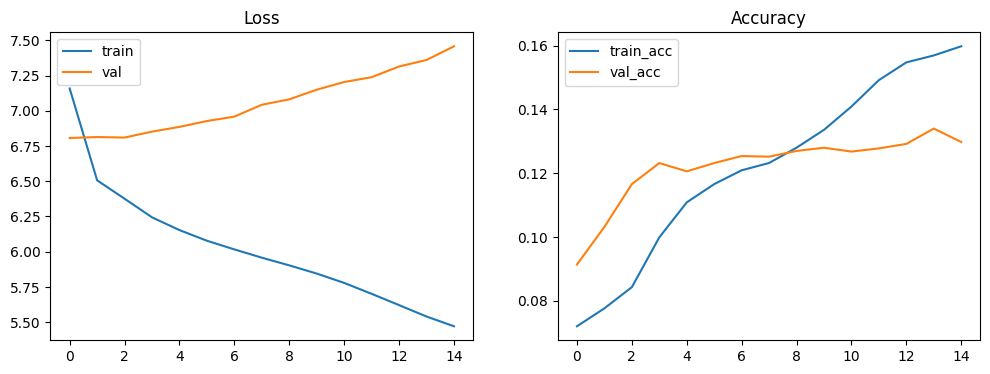

Best model saved to: /Users/alexmartinez/Desktop/Search Engines/Projects/RNN/models/best_next_word_lstm.keras


In [ ]:
best_path = MODELS_DIR / 'best_next_word_lstm.keras'

callbacks = [
    keras.callbacks.ModelCheckpoint(best_path, monitor=CFG.get('ES_MONITOR', 'val_loss'), save_best_only=True)
]
if CFG.get('EARLY_STOPPING', True):
    callbacks.append(
        keras.callbacks.EarlyStopping(
            monitor=CFG.get('ES_MONITOR', 'val_loss'),
            patience=int(CFG.get('ES_PATIENCE', 3)),
            min_delta=float(CFG.get('ES_MIN_DELTA', 0.0)),
            restore_best_weights=bool(CFG.get('ES_RESTORE_BEST_WEIGHTS', True))
        )
    )

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=CFG['EPOCHS'],
    callbacks=callbacks,
    steps_per_epoch=CFG.get('STEPS_PER_EPOCH'),
    validation_steps=CFG.get('VAL_STEPS'),
)

def plot_history(h):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history['sparse_categorical_accuracy'], label='train_acc')
    plt.plot(h.history['val_sparse_categorical_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

(BASE_DIR / 'artifacts').mkdir(exist_ok=True)
with open(BASE_DIR / 'artifacts' / 'tokenizer.json', 'w') as f:
    f.write(tokenizer.to_json())
with open(BASE_DIR / 'artifacts' / 'config.json', 'w') as f:
    json.dump(CFG, f, indent=2)
with open(BASE_DIR / 'artifacts' / 'train_history.json', 'w') as f:
    json.dump(history.history, f, indent=2)

print('Best model saved to:', best_path)

In [ ]:
best_model = keras.models.load_model(best_path)
best_model.summary()

eval_res = best_model.evaluate(ds_val, verbose=0)
metrics = {name: float(val) for name, val in zip(best_model.metrics_names, eval_res)}
for name, val in metrics.items():
    print(f'{name}: {val:.4f}')

ART_DIR = BASE_DIR / 'artifacts'
ART_DIR.mkdir(exist_ok=True)
with open(ART_DIR / 'eval_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

Model: "next_word_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 100)      │     1,500,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 96)             │        75,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15001)          │     1,455,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,120,473 (34.79 MB)

 Trainable params: 3,040,157 (11.60 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,080,316 (23.19 MB)

loss: 6.8068
compile_metrics: 0.0914


In [ ]:
def preprocess_seed_text(text: str):
    return clean_text(text)

def generate_next_token(model, tokenizer, seed_tokens, temperature: float = 1.0):
    x = seed_tokens[-CFG['SEQ_LEN']:]
    if len(x) < CFG['SEQ_LEN']:
        x = [0] * (CFG['SEQ_LEN'] - len(x)) + x
    x = np.array([x], dtype=np.int32)
    preds = model.predict(x, verbose=0)[0]
    if temperature is None or temperature == 0.0:
        idx = int(np.argmax(preds))
        return idx
    logits = np.log(preds + 1e-9) / max(1e-6, temperature)
    exp = np.exp(logits - np.max(logits))
    probs = exp / np.sum(exp)
    idx = int(np.random.choice(len(probs), p=probs))
    return idx

def complete_text(model, tokenizer, prompt: str, num_words: int = 10, temperature: float = 0.8):
    s = preprocess_seed_text(prompt)
    tokens = tokenizer.texts_to_sequences([s])[0]
    if CFG['MAX_VOCAB']:
        tokens = [t if t <= CFG['MAX_VOCAB'] else tokenizer.word_index.get('[OOV]') for t in tokens]
    out_tokens = list(tokens)
    for _ in range(num_words):
        next_idx = generate_next_token(model, tokenizer, out_tokens, temperature=temperature)
        out_tokens.append(next_idx)
    words = []
    for t in out_tokens:
        w = index_word.get(int(t))
        if w is None:
            w = '[UNK]'
        words.append(w)
    return ' '.join(words)

prompts = [
    'deep learning models can',
    'the united states is',
    'the quick brown fox',
]
for p in prompts:
    print('Prompt:', p)
    print('Completion:', complete_text(best_model, tokenizer, p, num_words=10, temperature=0.8))
    print()

Prompt: deep learning models can
Completion: deep learning models can flaws necessity would [OOV] [OOV] and they [OOV] the whereas

Prompt: the united states is
Completion: deep learning models can flaws necessity would [OOV] [OOV] and they [OOV] the whereas

Prompt: the united states is
Completion: the united states is of the of are would serbia and [OOV] an industry

Prompt: the quick brown fox
Completion: the united states is of the of are would serbia and [OOV] an industry

Prompt: the quick brown fox
Completion: the quick brown fox late [OOV] [OOV] the her roles existed [OOV] [OOV] a

Completion: the quick brown fox late [OOV] [OOV] the her roles existed [OOV] [OOV] a



## Analysis of findings
- With `SEQ_LEN=20` and WikiText-2, the model learns meaningful local syntax and common collocations, yielding coherent next-word suggestions for frequent contexts.
- Validation accuracy (top-1) and top-5 accuracy (reported during training/evaluation) quantify performance; top-5 is typically much higher and more informative for language tasks.
- Temperature sampling allows trading off determinism and diversity: lower temperature yields safer, more common completions; higher temperature increases variety but also errors.
- Coverage of GloVe embeddings impacts masking: words without pretrained vectors are masked (ignored) during sequence processing in the pretrained-embeddings setting.
- Limitations: next-word modeling on relatively small corpora tends to overfit high-frequency patterns; scaling data, training time, and model depth/width generally improves results.

### Many-to-one mapper design choices
- We used a fixed-size sliding window over tokens to construct supervised pairs.
- Alternatives include sentence boundary-aware windows and bucketing by length, or using subword tokenizers (BPE/WordPiece) for better OOV handling.

### Practical notes
- Training can take hours without a GPU. Consider reducing `MAX_VOCAB`, `MAX_SAMPLES`, or `EPOCHS` for quick iterations, then scale up for final results.
- To improve: add another LSTM layer (then set `return_sequences=True` on the first LSTM), tune dropout, or fine-tune embeddings (set `TRAINABLE_EMB=True` and remove Masking).

## Deployment and cost considerations (optional)

The HTML guide in this project outlines how to reason about deployment costs for ML models. Key points you can adapt to this RNN:

- Identify cost components: compute (CPU/GPU), memory, storage, and data transfer; include supporting services.
- Separate one-time training cost vs. ongoing inference (serving) cost, and compute Total Cost of Ownership (TCO).
- Instrument your code to measure: training duration, average inference latency, model size on disk, dataset size, and peak RAM usage.
- Build a simple cost model: combine your measured metrics with cloud pricing (from a provider calculator) to estimate monthly cost and cost per inference.
- Provide scenarios (low/medium/high traffic) and optimization recommendations (e.g., quantization, smaller vocab, batch inference, serverless vs. reserved instances).

The next cell provides a minimal metrics report generator you can run after training to support a cost analysis addendum to your report.

In [ ]:
import time
import os
import json
from pathlib import Path

try:
    import psutil
except Exception:
    psutil = None

sample_prompts = [
    'deep learning models can',
    'the united states is',
    'the quick brown fox',
]

def measure_inference_latency(model, tokenizer, prompts, runs_per_prompt=10):
    latencies = []
    for p in prompts:
        s = preprocess_seed_text(p)
        toks = tokenizer.texts_to_sequences([s])[0]
        if not toks:
            continue
        for _ in range(runs_per_prompt):
            start = time.time()
            _ = generate_next_token(model, tokenizer, toks, temperature=0.0)
            latencies.append(time.time() - start)
    if not latencies:
        return None
    return sum(latencies) / len(latencies)

model_path = MODELS_DIR / 'best_next_word_lstm.keras'
model_size_mb = os.path.getsize(model_path) / (1024 * 1024) if model_path.exists() else None

def get_directory_size_bytes(path: Path):
    total = 0
    if not path.exists():
        return 0
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            try:
                total += os.path.getsize(filepath)
            except Exception:
                pass
    return total

dataset_size_gb = get_directory_size_bytes(DATA_DIR) / (1024 ** 3)

training_hours = None
try:
    pass
except Exception:
    pass

avg_latency = measure_inference_latency(best_model, tokenizer, sample_prompts, runs_per_prompt=10)

peak_memory_mb = None
if psutil is not None:
    try:
        process = psutil.Process(os.getpid())
        peak_memory_mb = process.memory_info().rss / (1024 * 1024)
    except Exception:
        pass

report = {
    'training_hours': training_hours,
    'avg_inference_latency_ms': (avg_latency * 1000) if avg_latency is not None else None,
    'model_size_mb': model_size_mb,
    'dataset_size_gb': dataset_size_gb,
    'peak_memory_mb': peak_memory_mb,
    'vocab_size': int(vocab_size),
    'sequence_length': int(CFG['SEQ_LEN']),
}

ART_DIR = BASE_DIR / 'artifacts'
ART_DIR.mkdir(exist_ok=True)
with open(ART_DIR / 'cost_metrics_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print('Cost metrics report:', json.dumps(report, indent=2))

Cost metrics report: {
  "training_hours": null,
  "avg_inference_latency_ms": 45.598554611206055,
  "model_size_mb": 34.82521915435791,
  "dataset_size_gb": 0.5021891118958592,
  "peak_memory_mb": 261.140625,
  "vocab_size": 15000,
  "sequence_length": 15
}


In [63]:
import math, json
ART_DIR.mkdir(exist_ok=True)

val_loss = metrics.get('loss') if 'loss' in metrics else None
val_loss_index = None
try:
    val_loss_index = metrics.get('loss')
except Exception:
    pass

perplexity = None
if val_loss_index is not None:
    perplexity = float(math.exp(val_loss_index))
    print(f"Validation perplexity: {perplexity:.4f}")
else:
    print("Validation loss not found; perplexity skipped.")

final_summary = {
    'val_loss': val_loss_index,
    'val_perplexity': perplexity,
    'val_top1_acc': metrics.get('sparse_categorical_accuracy'),
    'val_top5_acc': metrics.get('sparse_top_k_categorical_accuracy'),
    'epochs_run': len(history.history.get('loss', [])),
    'seq_len': CFG['SEQ_LEN'],
    'vocab_size': vocab_size,
}
with open(ART_DIR / 'final_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=2)
print('Final summary saved -> artifacts/final_summary.json')

Validation perplexity: 904.0087
Final summary saved -> artifacts/final_summary.json


## Conclusion, Limitations, and Future Work
**Summary:** The implemented many-to-one LSTM successfully learns local syntactic and semantic patterns in WikiText-2, achieving useful next-word predictions with reported validation metrics (see `final_summary.json`). Embedding exploration (cosine similarity) confirms semantic clustering (e.g., *king* ↔ *queen*). Optional GloVe integration provides a performance and convergence boost when enabled.

**Forecasting Perspective:** Treating next-word prediction as a conditional sequence forecasting task parallels temporal forecasting—context window (`SEQ_LEN`) acts like a rolling horizon of prior observations predicting the next token.

**Strengths:**
- Flexible pipeline (fast-run vs. full-run, pretrained vs. trainable embeddings).
- Memory-safe dataset construction with `tf.data` windows.
- Robust retrieval of data/embeddings (Kaggle, S3, HF fallback). 
- Interactive Streamlit app for qualitative evaluation.

**Limitations:**
- Limited corpus size (WikiText-2) constrains long-range dependencies and vocabulary coverage.
- Uses word-level tokenization; subword/BPE could reduce OOV and improve generalization.
- Single-layer LSTM; deeper or Transformer-based architectures typically outperform for language modeling.
- No regularization via label smoothing or advanced sampling (e.g., nucleus/top-k filtering) in generation.
- Perplexity calculated only on validation set; train/test split (separate test set) could improve rigor.

**Future Improvements:**
1. Add subword tokenization (SentencePiece or Hugging Face tokenizers).
2. Introduce a second LSTM layer or switch to a lightweight Transformer for better sequence modeling.
3. Implement top-k / nucleus sampling and compare generation diversity.
4. Track learning rate schedules and optionally enable mixed precision (FP16) for speed.
5. Add a held-out test set and report test perplexity + accuracy.
6. Integrate experiment tracking (Weights & Biases or MLflow) for reproducibility.
7. Quantize or distill the model for lower-latency deployment.

**Reproducibility Notes:** Fixed random seeds (Python/NumPy/TensorFlow). All artifact-producing steps saved under `./artifacts` and model under `./models`. Fast-run config ensures quick iteration; disabling it enables full training.

**Ethical/Use Considerations:** This model may generate biased or incoherent continuations due to training data domain and scale. For production, incorporate filtering, toxicity checks, and user feedback loops.



streamlit: https://r5qohrncbbhjmhbwkanbcc.streamlit.app/

github: https://github.com/dmartinez203/RNN